In [7]:
import json
import time

import numpy as np
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

def classify_subcategory(text):
    likelihoods = [0 for _ in range(len(SUBCATEGORIES))]
    text = set(removePunctuation(text).lower().split())
    for token in text:
        if token in stop_words:
            continue

        if token in word_to_subcat:
            for i in range(len(SUBCATEGORIES)):
                likelihoods[i] += word_to_subcat[token][i]
        else:
            print('Token not in word-to-subcat:', token)

    return SUBCATEGORIES[likelihoods.index(max(likelihoods))]


def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)


with open('../stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('../subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

time_now = time.perf_counter()
with open('word-to-subcat-normalized.json') as f:
    word_to_subcat = json.load(f)
print('Time to load word-to-subcat-normalized:', time.perf_counter() - time_now, 'seconds')

for word in word_to_subcat:
    if normalized_hhi(word_to_subcat[word]) < 0.01:
        print(word)
    # factor = normalized_hhi(word_to_subcat[word])
    factor = normalized_hhi(
        word_to_subcat[word])**5 / sum(word_to_subcat[word])
    word_to_subcat[word] = [factor * i for i in word_to_subcat[word]]


print('=====Begin Testing=====')
time_now = time.perf_counter()

questions = open('questions.json')
counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))]
                    for _ in range(len(SUBCATEGORIES))]
for line in questions:
    data = json.loads(line)
    if 'subcategory' not in data:
        continue

    counter += 1
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES:
        continue

    if data['type'] == 'tossup':
        prediction = classify_subcategory(data['question'])
    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        prediction = classify_subcategory(
            data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2])

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {correct / counter} ({correct}/{counter})')
print('Time:', time.perf_counter() - time_now, 'seconds')
print('Confusion Matrix:')
for row in confusion_matrix:
    print(row)


Time to load word-to-subcat-normalized: 3.2449763430049643 seconds
=====Begin Testing=====
9666/10000
19347/20000
28895/30000
38283/40000
47447/50000
56802/60000
66185/70000
75394/80000
84831/90000
94361/100000
103901/110000
113476/120000
123425/130000
=====End Testing=====
Accuracy: 0.9505446396770747 (128103/134768)
Time: 42.88400623599591 seconds
Confusion Matrix:
[7372, 40, 0, 41, 36, 0, 27, 1, 7, 5, 0, 11, 7, 10, 2, 0, 43, 47, 3, 15, 13, 15, 8, 0, 4, 0, 2]
[24, 6259, 1, 13, 11, 0, 7, 0, 13, 5, 0, 3, 4, 2, 2, 3, 35, 31, 1, 6, 19, 8, 1, 0, 2, 0, 1]
[2, 6, 374, 1, 14, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 1, 3, 0, 0, 52, 4, 1, 0, 0, 0, 0]
[13, 40, 1, 4898, 22, 0, 3, 2, 8, 2, 0, 8, 0, 3, 0, 2, 21, 41, 0, 7, 24, 14, 0, 0, 1, 0, 0]
[16, 12, 0, 18, 4231, 0, 2, 0, 3, 14, 0, 8, 3, 0, 0, 1, 14, 19, 2, 8, 21, 1, 2, 0, 0, 0, 3]
[77, 45, 2, 26, 47, 792, 2, 0, 1, 2, 0, 5, 0, 3, 0, 6, 11, 16, 0, 5, 12, 10, 1, 0, 1, 0, 4]
[12, 10, 0, 1, 0, 0, 7676, 4, 36, 27, 0, 18, 11, 5, 0, 6, 29, 20, 2, 15, 3, 7, 6

<AxesSubplot:>

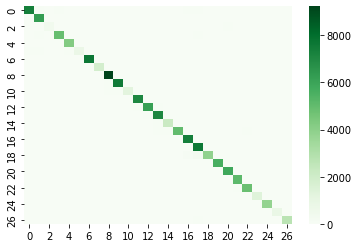

In [8]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

In [9]:
# ConfusionMatrixDisplay(np.array(confusion_matrix), display_labels='').plot()